In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.data import load_ohlcv
from src.features import add_features, add_target, get_feature_columns
from src.split import time_train_test_split
from src.train import train_and_save
from src.modeling import evaluate_classifier
from src.predict import predict_latest

plt.rcParams["figure.figsize"] = (10, 4)

symbol = "BTC-USD"
start = "2018-01-01"
end = None
horizon_days = 1
test_size = 0.20

n_splits_cv = 5
n_trials = 50
random_seed = 42
artifacts_dir = "../artifacts"  # notebook is inside notebooks/


c:\Users\niloo\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = load_ohlcv(symbol=symbol, start=start, end=end)
df.head()


,date,open,high,low,close,volume
0,2018-01-01,14112.200195,14112.200195,13154.700195,13657.200195,10291200000
1,2018-01-02,13625.000000,15444.599609,13163.599609,14982.099609,16846600192
2,2018-01-03,14978.200195,15572.799805,14844.500000,15201.000000,16871900160
3,2018-01-04,15270.700195,15739.700195,14522.200195,15599.200195,21783199744
4,2018-01-05,15477.200195,17705.199219,15202.799805,17429.500000,23840899072


Date range: 2018-01-01 → 2026-02-11
Rows: 2964


,date,open,high,low,close,volume
count,2964,2964.000000,2964.000000,2964.000000,2964.000000,2.964000e+03
mean,2022-01-21 12:00:00,37939.523571,38685.199812,37137.021463,37955.728929,3.046311e+10
min,2018-01-01 00:00:00,3236.274658,3275.377930,3191.303467,3236.761719,2.923670e+09
25%,2020-01-11 18:00:00,9526.624756,9701.060791,9325.418213,9525.654053,1.534708e+10
50%,2022-01-21 12:00:00,27796.959961,28336.328125,27253.883789,27808.447266,2.619422e+10
75%,2024-02-01 06:00:00,58473.225586,59820.956055,57186.511719,58482.781250,4.010046e+10
max,2026-02-11 00:00:00,124752.140625,126198.070312,123196.046875,124752.531250,3.509679e+11
std,NaN,32505.612231,33027.579503,31936.223249,32506.207053,2.211285e+10


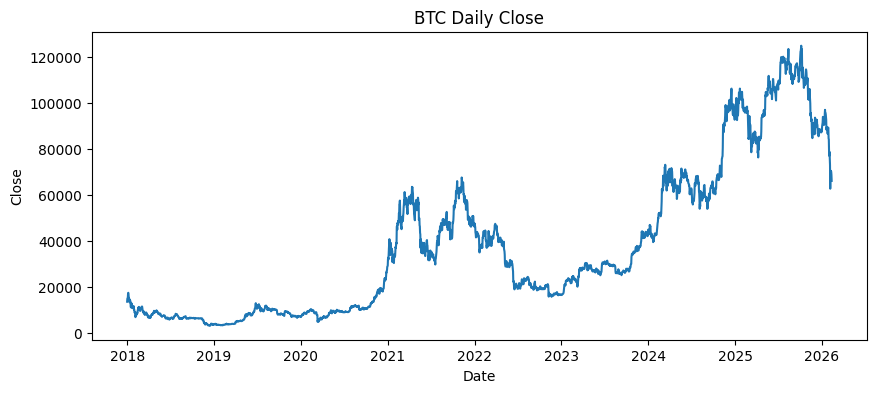

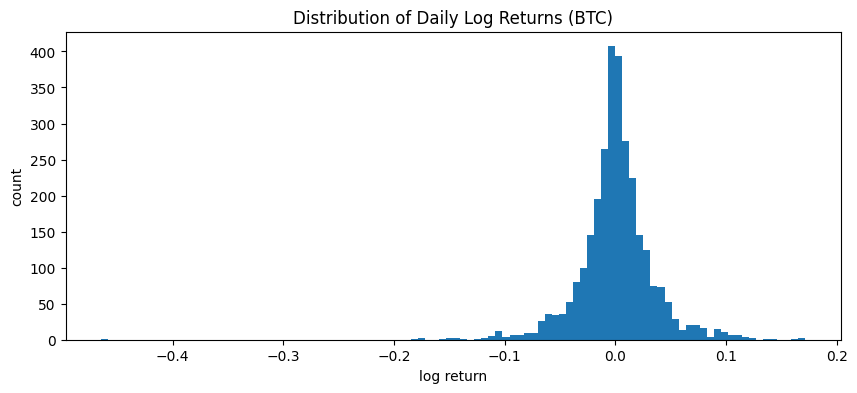

Return mean: 0.0005321551665555704
Return std : 0.03430257863479548


In [3]:
print("Date range:", df["date"].min().date(), "→", df["date"].max().date())
print("Rows:", len(df))
display(df.describe())

# Price plot
plt.plot(df["date"], df["close"])
plt.title("BTC Daily Close")
plt.xlabel("Date")
plt.ylabel("Close")
plt.show()

# Returns distribution
log_ret = np.log(df["close"]).diff().dropna()
plt.hist(log_ret, bins=100)
plt.title("Distribution of Daily Log Returns (BTC)")
plt.xlabel("log return")
plt.ylabel("count")
plt.show()

print("Return mean:", log_ret.mean())
print("Return std :", log_ret.std())


1) returns are heavy-tailed, volatility clusters: nonlinear models help

2) mean return is small vs variance: prediction is hard

In [4]:
# Build features + target
df_feat = add_features(df)
df_lab = add_target(df_feat, horizon_days=horizon_days)
feature_cols = get_feature_columns(df_lab)

usable = df_lab.dropna(subset=feature_cols + ["y"]).reset_index(drop=True)
print("Usable rows:", len(usable))
print("Up-day rate:", usable["y"].mean())


Usable rows: 2915
Up-day rate: 0.5101200686106346


In [5]:
#train/test split (time_based)
idx_train, idx_test = time_train_test_split(len(usable), test_size=test_size)
train_df = usable.iloc[idx_train].copy()
test_df  = usable.iloc[idx_test].copy()

print("Train:", train_df["date"].min().date(), "→", train_df["date"].max().date(), "n=", len(train_df))
print("Test :", test_df["date"].min().date(),  "→", test_df["date"].max().date(),  "n=", len(test_df))


Train: 2018-02-19 → 2024-07-08 n= 2332
Test : 2024-07-09 → 2026-02-11 n= 583


In [6]:
#train + tune
model, best_params, best_cv_auc, train_metrics = train_and_save(
    train_df=train_df,
    feature_cols=feature_cols,
    artifacts_dir=artifacts_dir,
    n_splits_cv=n_splits_cv,
    n_trials=n_trials,
    random_seed=random_seed
)

best_params, best_cv_auc, train_metrics


[I 2026-02-11 17:00:09,416] A new study created in memory with name: no-name-6f72a572-bb46-40b9-ae0d-4ea9b04ece31
[I 2026-02-11 17:00:10,163] Trial 0 finished with value: 0.5376355744671433 and parameters: {'learning_rate': 0.03574712922600244, 'max_depth': 10, 'max_leaf_nodes': 191, 'min_samples_leaf': 124, 'l2_regularization': 1.2363188277052228e-05, 'max_bins': 93}. Best is trial 0 with value: 0.5376355744671433.
[I 2026-02-11 17:00:10,694] Trial 1 finished with value: 0.5367824049558072 and parameters: {'learning_rate': 0.012184186502221764, 'max_depth': 9, 'max_leaf_nodes': 159, 'min_samples_leaf': 145, 'l2_regularization': 1.3934502251337597e-06, 'max_bins': 250}. Best is trial 0 with value: 0.5376355744671433.
[I 2026-02-11 17:00:11,191] Trial 2 finished with value: 0.5139271284217413 and parameters: {'learning_rate': 0.16967533607196555, 'max_depth': 3, 'max_leaf_nodes': 58, 'min_samples_leaf': 45, 'l2_regularization': 0.000134801802908908, 'max_bins': 164}. Best is trial 0 wit

({'learning_rate': 0.04774074800933106,
  'max_depth': 4,
  'max_leaf_nodes': 22,
  'min_samples_leaf': 187,
  'l2_regularization': 0.7804364319810383,
  'max_bins': 66,
  'random_state': 42},
 0.5467698218195957,
 Metrics(accuracy=0.6672384219554031, roc_auc=0.7280706402740824, logloss=0.6425908658612305))

In [7]:
#evaluate on holdout + report table
X_test = test_df[feature_cols].to_numpy()
y_test = test_df["y"].to_numpy().astype(int)

test_metrics = evaluate_classifier(model, X_test, y_test)

report = pd.DataFrame([{
    "Model": "Tuned HistGradientBoosting",
    "Train AUC": train_metrics.roc_auc,
    "Test AUC": test_metrics.roc_auc,
    "Test Accuracy": test_metrics.accuracy,
    "Test LogLoss": test_metrics.logloss,
    "Best CV AUC": best_cv_auc
}])

report


,Model,Train AUC,Test AUC,Test Accuracy,Test LogLoss,Best CV AUC
0,Tuned HistGradientBoosting,0.728071,0.484465,0.471698,0.710978,0.54677


In [8]:
#Latest prediction
latest = predict_latest(usable, feature_cols=feature_cols, artifacts_dir=artifacts_dir)
latest


{'date': '2026-02-11', 'p_up': 0.6956454074276865}

In [11]:
# After training:
# model = trained pipeline
# test_df = holdout dataframe with columns date, y, etc.

p_test = model.predict_proba(test_df[feature_cols].to_numpy())[:, 1]

test_pred_df = test_df[["date", "y"]].copy()
test_pred_df["p_up"] = p_test
test_pred_df = test_pred_df.reset_index(drop=True)
test_pred_df.head()


,date,y,p_up
0,2024-07-09,0,0.411681
1,2024-07-10,0,0.435022
2,2024-07-11,1,0.464414
3,2024-07-12,1,0.381029
4,2024-07-13,1,0.408020


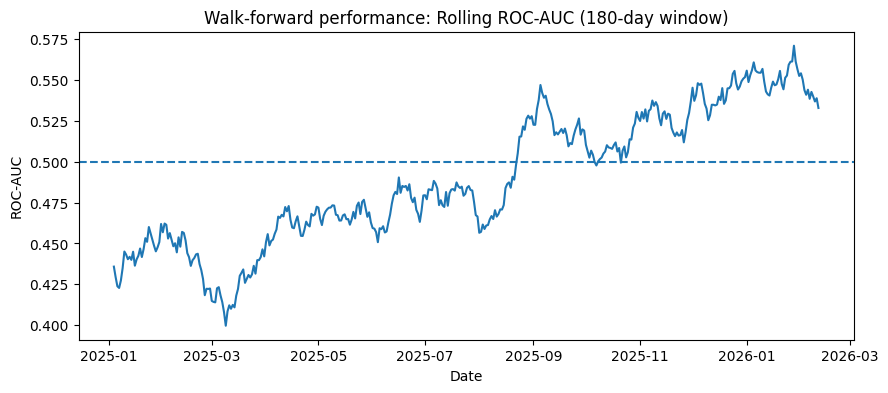

In [12]:
from sklearn.metrics import roc_auc_score

def rolling_auc(df_pred, window=180):
    """
    Rolling ROC-AUC over a trailing window.
    window=180 ~ about 6 months of daily data.
    """
    auc_vals = []
    dates = []
    y = df_pred["y"].to_numpy()
    p = df_pred["p_up"].to_numpy()

    for i in range(window, len(df_pred) + 1):
        y_win = y[i-window:i]
        p_win = p[i-window:i]

        # ROC-AUC undefined if window contains only one class
        if len(np.unique(y_win)) < 2:
            auc = np.nan
        else:
            auc = roc_auc_score(y_win, p_win)

        auc_vals.append(auc)
        dates.append(df_pred["date"].iloc[i-1])

    out = pd.DataFrame({"date": dates, "rolling_auc": auc_vals})
    return out

roll = rolling_auc(test_pred_df, window=180)

plt.plot(roll["date"], roll["rolling_auc"])
plt.axhline(0.5, linestyle="--")  # random baseline
plt.title("Walk-forward performance: Rolling ROC-AUC (180-day window)")
plt.xlabel("Date")
plt.ylabel("ROC-AUC")
plt.show()


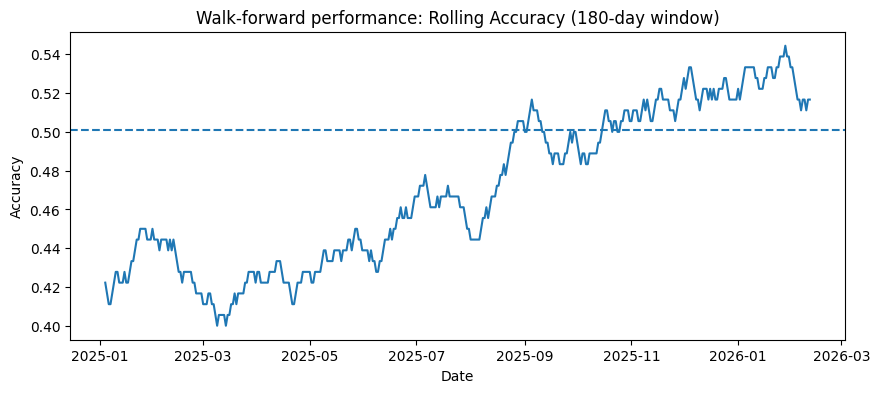

In [13]:
def rolling_accuracy(df_pred, window=180, threshold=0.5):
    acc_vals = []
    dates = []
    y = df_pred["y"].to_numpy()
    p = df_pred["p_up"].to_numpy()

    for i in range(window, len(df_pred) + 1):
        y_win = y[i-window:i]
        p_win = p[i-window:i]
        pred_win = (p_win >= threshold).astype(int)
        acc = (pred_win == y_win).mean()
        acc_vals.append(acc)
        dates.append(df_pred["date"].iloc[i-1])

    return pd.DataFrame({"date": dates, "rolling_acc": acc_vals})

roll_acc = rolling_accuracy(test_pred_df, window=180, threshold=0.5)

plt.plot(roll_acc["date"], roll_acc["rolling_acc"])
plt.axhline(test_pred_df["y"].mean(), linestyle="--")  # naive baseline accuracy if always predict majority
plt.title("Walk-forward performance: Rolling Accuracy (180-day window)")
plt.xlabel("Date")
plt.ylabel("Accuracy")
plt.show()


1) Rolling AUC near 0.5 ⇒ model is basically random in that regime

2) If it spikes above 0.55 but collapses later ⇒ regime dependence

3) If it stays stable above 0.5 ⇒ more robust signal

Build returns and positions

In [14]:
# We need the realized next-day return for the same rows
# test_df already has 'future_log_ret' from add_target()

bt = test_df[["date", "future_log_ret"]].copy().reset_index(drop=True)
bt["p_up"] = p_test

THRESH = 0.55          # change this (0.50, 0.55, 0.60)
COST_BPS = 10          # 10 bps = 0.10% per trade side
COST = COST_BPS / 10000.0

# Long if confident, else cash
bt["pos"] = (bt["p_up"] >= THRESH).astype(int)

# Trades happen when pos changes
bt["trade"] = bt["pos"].diff().abs().fillna(bt["pos"]).astype(int)

# Strategy daily log return: pos * asset_return - trade_cost
bt["strat_log_ret"] = bt["pos"] * bt["future_log_ret"] - bt["trade"] * COST

# Benchmark: buy-and-hold (always long)
bt["bh_log_ret"] = bt["future_log_ret"]


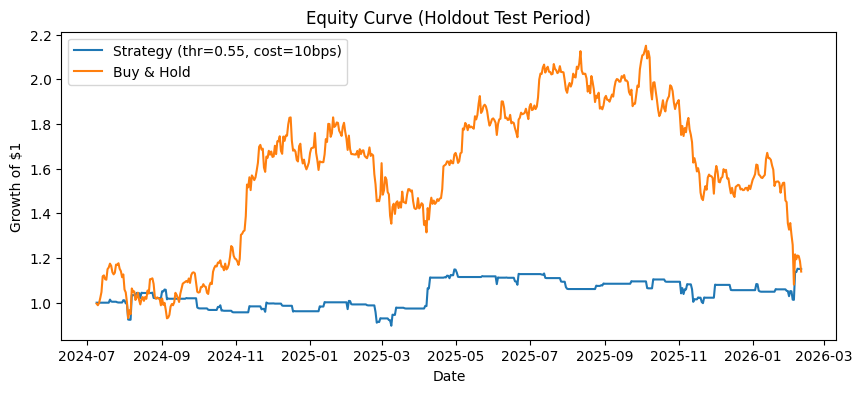

In [15]:
# Equity curves (log returns -> cumulative)
bt["strat_equity"] = np.exp(bt["strat_log_ret"].cumsum())
bt["bh_equity"] = np.exp(bt["bh_log_ret"].cumsum())

plt.plot(bt["date"], bt["strat_equity"], label=f"Strategy (thr={THRESH}, cost={COST_BPS}bps)")
plt.plot(bt["date"], bt["bh_equity"], label="Buy & Hold")
plt.title("Equity Curve (Holdout Test Period)")
plt.xlabel("Date")
plt.ylabel("Growth of $1")
plt.legend()
plt.show()


Convert to equity curves

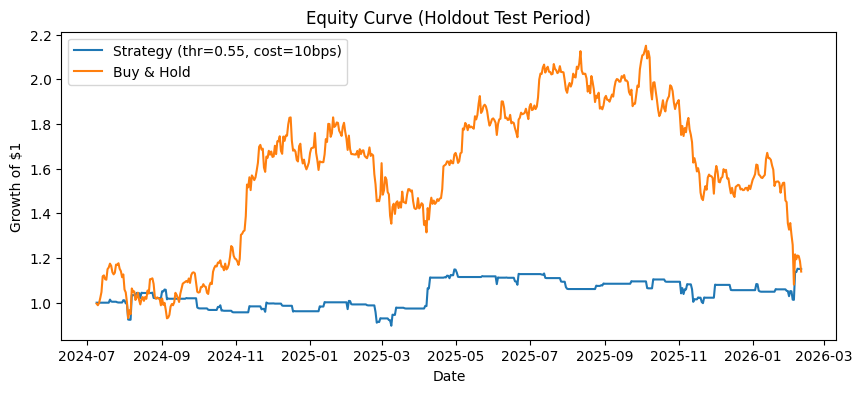

In [16]:
# Equity curves (log returns -> cumulative)
bt["strat_equity"] = np.exp(bt["strat_log_ret"].cumsum())
bt["bh_equity"] = np.exp(bt["bh_log_ret"].cumsum())

plt.plot(bt["date"], bt["strat_equity"], label=f"Strategy (thr={THRESH}, cost={COST_BPS}bps)")
plt.plot(bt["date"], bt["bh_equity"], label="Buy & Hold")
plt.title("Equity Curve (Holdout Test Period)")
plt.xlabel("Date")
plt.ylabel("Growth of $1")
plt.legend()
plt.show()


Compute key performance metrics (Sharpe, drawdown, turnover)

In [17]:
def sharpe_from_logrets(logrets, periods_per_year=365):
    # Approx: use mean/std of daily log returns
    mu = np.mean(logrets)
    sigma = np.std(logrets) + 1e-12
    return np.sqrt(periods_per_year) * mu / sigma

def max_drawdown(equity_curve):
    peak = np.maximum.accumulate(equity_curve)
    dd = equity_curve / peak - 1.0
    return float(dd.min())

strat_final = float(bt["strat_equity"].iloc[-1])
bh_final = float(bt["bh_equity"].iloc[-1])

strat_sharpe = sharpe_from_logrets(bt["strat_log_ret"].to_numpy())
bh_sharpe = sharpe_from_logrets(bt["bh_log_ret"].to_numpy())

strat_mdd = max_drawdown(bt["strat_equity"].to_numpy())
bh_mdd = max_drawdown(bt["bh_equity"].to_numpy())

turnover = float(bt["trade"].mean())  # fraction of days with a trade

summary = pd.DataFrame([{
    "Strategy": f"Threshold={THRESH}, Cost={COST_BPS}bps",
    "Final Equity": strat_final,
    "Sharpe (ann.)": strat_sharpe,
    "Max Drawdown": strat_mdd,
    "Trade rate": turnover,
}, {
    "Strategy": "Buy & Hold",
    "Final Equity": bh_final,
    "Sharpe (ann.)": bh_sharpe,
    "Max Drawdown": bh_mdd,
    "Trade rate": 0.0,
}])

summary


,Strategy,Final Equity,Sharpe (ann.),Max Drawdown,Trade rate
0,"Threshold=0.55, Cost=10bps",NaN,NaN,NaN,0.252144
1,Buy & Hold,NaN,NaN,NaN,0.000000


Sensitivity analysis across thresholds

In [18]:
def backtest_threshold(bt_base, thresholds, cost_bps=10):
    out_rows = []
    cost = cost_bps / 10000.0
    for thr in thresholds:
        bt = bt_base.copy()
        bt["pos"] = (bt["p_up"] >= thr).astype(int)
        bt["trade"] = bt["pos"].diff().abs().fillna(bt["pos"]).astype(int)
        bt["strat_log_ret"] = bt["pos"] * bt["future_log_ret"] - bt["trade"] * cost
        equity = np.exp(bt["strat_log_ret"].cumsum())
        out_rows.append({
            "threshold": thr,
            "final_equity": float(equity.iloc[-1]),
            "sharpe": sharpe_from_logrets(bt["strat_log_ret"].to_numpy()),
            "max_drawdown": max_drawdown(equity.to_numpy()),
            "trade_rate": float(bt["trade"].mean()),
        })
    return pd.DataFrame(out_rows)

threshold_grid = [0.50, 0.525, 0.55, 0.575, 0.60]
sens = backtest_threshold(bt[["date","future_log_ret","p_up"]], threshold_grid, cost_bps=COST_BPS)
sens


,threshold,final_equity,sharpe,max_drawdown,trade_rate
0,0.500,NaN,NaN,NaN,0.365352
1,0.525,NaN,NaN,NaN,0.300172
2,0.550,NaN,NaN,NaN,0.252144
3,0.575,NaN,NaN,NaN,0.152659
4,0.600,NaN,NaN,NaN,0.101201
